In [29]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

import matplotlib.pyplot as plt
%matplotlib inline

import hickle as hkl

def plot_multiple(images,cmap=True):
    ni = images.shape[0]
    plt.figure(figsize=(50,3))
    plt.axis('off')
    for i in range(ni):
        plt.axis('off')
        plt.subplot(1,ni,i+1)
        if cmap:
            plt.imshow(images[i].reshape([80,80]),cmap='gray')
        else:
            plt.imshow(images[i].reshape([80,80]))
        
def plot(image):
    plt.axis('off')
    plt.imshow(image.reshape([80,80]),cmap='gray')

In [2]:
# prepare dataset
_X = hkl.load('30Kaffine.hkl')
_Y = hkl.load('30Kaffine_label.hkl')

In [3]:
def batch_gen(X,y,N):
    while True:
        idx = np.random.choice(len(y),N)
        yield X[idx].astype('float32'),y[idx].astype('int32')

In [4]:
# A Convolutional Neural Network
#  input layer
l_in = lasagne.layers.InputLayer((None,80*80))
# reshape into an image
l_shape = lasagne.layers.ReshapeLayer(l_in,(-1,1,80,80))
# convol layer
l_conv = lasagne.layers.Conv2DLayer(l_shape,num_filters=3,filter_size=3,pad=1)
# output layer
l_out = lasagne.layers.DenseLayer(l_conv,num_units=30,nonlinearity=lasagne.nonlinearities.softmax)

In [5]:
# symbolic variables
X = T.matrix('X')
Y = T.ivector('Y')
# symbolic variable for network output and predicted class
output = lasagne.layers.get_output(l_out,X)
pred = output.argmax(-1)
# loss/cost function
#  take mean over minibatch
loss = T.mean(lasagne.objectives.categorical_crossentropy(output,Y))
# accuracy
acc = T.mean(T.eq(pred,Y))
# parameters
params = lasagne.layers.get_all_params(l_out)
# gradient and updates
grad = T.grad(loss,params)
updates = lasagne.updates.sgd(grad,params,learning_rate=0.05)
print updates

OrderedDict([(W, Elemwise{sub,no_inplace}.0), (b, Elemwise{sub,no_inplace}.0), (W, Elemwise{sub,no_inplace}.0), (b, Elemwise{sub,no_inplace}.0)])


/usr/local/lib/python2.7/dist-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


In [6]:
# build training function
train = theano.function([X,Y],[loss,acc],updates=updates)
# predicted class
predict = theano.function([X],pred)
# batch size
batch_size = 64
num_batches = _X.shape[0] // batch_size

In [8]:
train_batches = batch_gen(_X,_Y,64)

In [10]:
for epoch in range(1000):
    train_loss = 0
    train_acc = 0
    for _ in range(num_batches):
        X_, y_ = next(train_batches)
        loss, acc = train(X_,y_)
        train_loss += loss
        train_acc  += acc
    train_loss /= num_batches
    train_acc /= num_batches
        
    print 'Epoch : ',epoch,'Loss : ',train_loss,'Accuracy : ',train_acc 
        

Epoch :  0 Loss :  1.82051447066 Accuracy :  0.6015625
Epoch :  1 Loss :  0.640723786516 Accuracy :  0.849158653846
Epoch :  2 Loss :  0.410420407135 Accuracy :  0.907852564103
Epoch :  3 Loss :  0.279250723437 Accuracy :  0.935997596154
Epoch :  4 Loss :  0.218408211118 Accuracy :  0.952791132479
Epoch :  5 Loss :  0.172458975146 Accuracy :  0.963307959402
Epoch :  6 Loss :  0.136951516604 Accuracy :  0.971487713675
Epoch :  7 Loss :  0.124217960564 Accuracy :  0.975427350427
Epoch :  8 Loss :  0.115648348705 Accuracy :  0.979166666667
Epoch :  9 Loss :  0.0794979133984 Accuracy :  0.985276442308
Epoch :  10 Loss :  0.0853709150872 Accuracy :  0.986511752137
Epoch :  11 Loss :  0.0609980822801 Accuracy :  0.989983974359
Epoch :  12 Loss :  0.0607804008125 Accuracy :  0.98985042735
Epoch :  13 Loss :  0.0556386156356 Accuracy :  0.991920405983
Epoch :  14 Loss :  0.0755853186236 Accuracy :  0.987680288462
Epoch :  15 Loss :  0.0520023207691 Accuracy :  0.993689903846
Epoch :  16 Loss :

KeyboardInterrupt: 

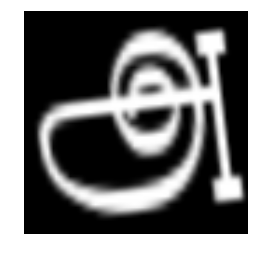

In [11]:
plot(_X[0])

In [17]:
print predict(_X[4].reshape([1,80*80]))

[4]


In [18]:
# after applying filters
filtered = lasagne.layers.get_output(l_conv,X)
get_filters = theano.function([X],filtered)

In [24]:
images = get_filters(_X[:30])
print images.shape

(30, 3, 80, 80)


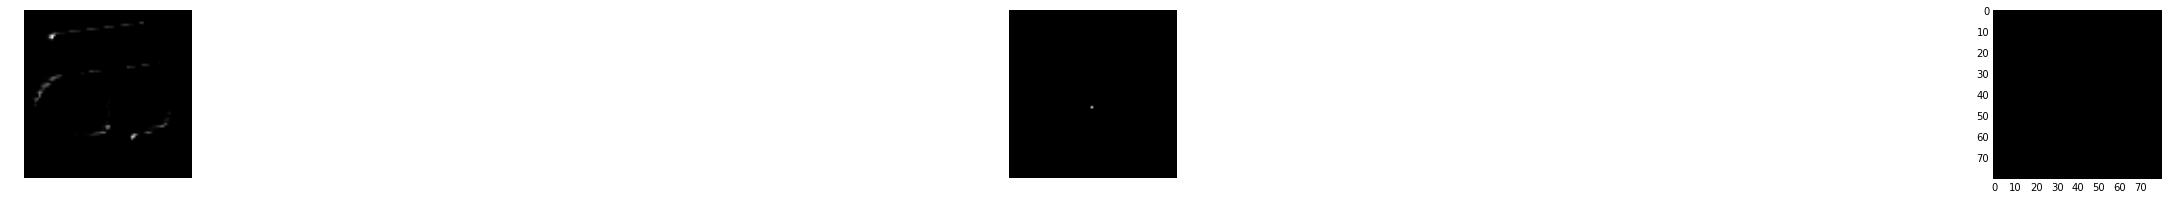

In [38]:
plot_multiple(images[12].reshape([3,80*80]))

In [55]:
# save all weights to file
weights = l_out.W.get_value()

In [58]:
weights = (weights.T).reshape([30,3,80*80])

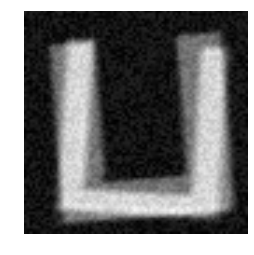

In [80]:
plot(weights[20][2])